<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## K-Means from Scratch

Let's first do a simple example illustrating how to perform K-Means clustering without the help of Scikit-Learn.  We will generate some synthetic cluster data below and will then define a `build_clusters()` function to perform K-Means clustering.

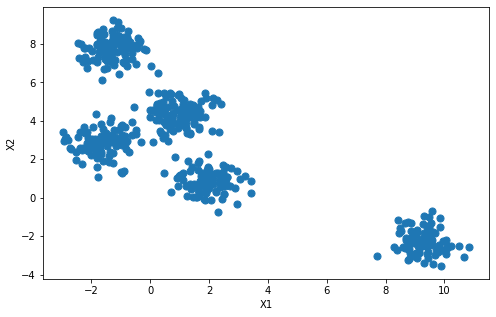

In [3]:
# Create a fake dataset to demonstrate clustering on
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=500, centers=5,cluster_std=0.6, random_state=0)

# Visualize the data
plt.figure(figsize=(8,5))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [9]:
# Function to perform K-Means clustering given a set of data (X) and a target number of clusters (num_clusters)

from sklearn.metrics import pairwise_distances_argmin

def build_clusters(X, n_clusters, rseed=0):
    
    # Randomly choose n_clusters initial cluster centers from among the X points
    rand_generator = np.random.RandomState(rseed)
    i = rand_generator.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # Assign labels to each datapoint based on closest center
        labels = pairwise_distances_argmin(X, centers, metric='euclidean')
        
        # Find new centers from means of datapoints assigned to each cluster
        new_centers = np.array([X[labels == i].mean(axis=0)for i in range(n_clusters)])
        
        # Terminate loop if cluster centers have not moved
        if np.all(centers == new_centers):
            break
        # Otherwise, use the new centers and repeat the loop
        centers = new_centers
    
    return centers, labels

Let's now run our function on the synthetic data and visualize the clusters it produces.

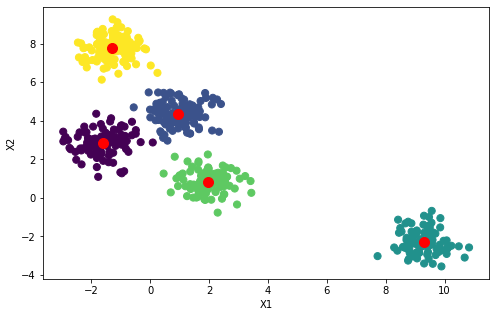

In [10]:
num_clusters = 5
centers, labels = build_clusters(X, num_clusters)

# Visualize the clusters, colored by label
plt.figure(figsize=(8,5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

# Plot the cluster centers
plt.scatter(centers[:,0],centers[:,1],s=100,c='red')

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## K-Means on Digits

Now let's try a more sophisticated example, using K-Means clustering to group images of handwritten digits.  Our objective is to group images of the same digit together (e.g. all the "1"s in a group together, all the "2"s together, etc.

In [5]:
# Load the data
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

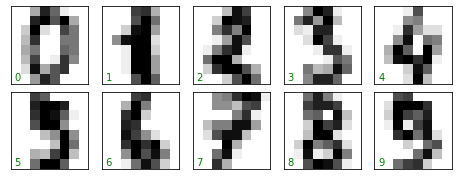

In [6]:
# Visualize a few of the digit images
fig, axes = plt.subplots(2, 5, figsize=(8, 3),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

We will use Scikit-Learn's implementation of K-Means to cluster our images.  The number of clusters we seek is 10, because we have 10 digits represented in the images.

In [7]:
# Cluster the images using K-Means
kmeans_model = KMeans(n_clusters=10, random_state=0)
clusters = kmeans_model.fit_predict(digits.data)

Let's visualize the cluster centers, which can be interpreted as a "typical" digit representative of each cluster

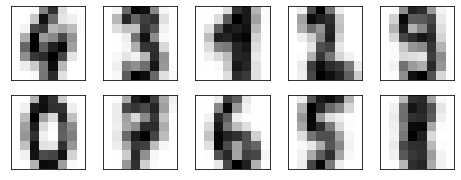

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans_model.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(ax.flat, centers):
    ax.set(xticks=[], yticks=[])
    ax.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Above we can see that the 10 cluster centers found through K-Means do a pretty good job of representing each of our 10 digits.

But what if we didn't know the number of clusters that we wanted up-front?  We could use the "elbow method" to determine a reasonable number of clusters.  The elbow method plots the "within cluster sum of squares (WCSS)", or the sum of the distance from each point to its respective cluster center.  As we might expect, the more clusters we create the lower the WCSS would be.  However, we also do not want to use too many clusters, or we will have very few points assigned to each cluster.  We plot the elbow diagram and generally will choose a number of clusters corresponding to the "elbow" point in the curve.

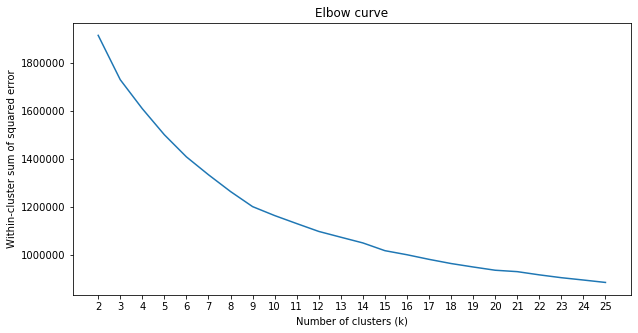

In [14]:
# Select number of clusters to use for KMeans clustering

wcss_list = list()
k_range = range(2,26)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(digits.data)
    wcss=0 # within cluster sum of squares
    # For each row, calculate distance to nearest centroid and add squared distance to wcss total
    for i in range(digits.data.shape[0]):
        distances = np.linalg.norm((digits.data[i] - km.cluster_centers_), ord=2, axis=1) # Calculate distances from centroids
        wcss += np.min(distances)**2 # Add squared distance from closest centroid
    wcss_list.append(wcss)

fig = plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss_list)
plt.title('Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squared error')
plt.xticks(k_range)
plt.show()

If we did not know how many clusters we wanted (which is often the case in clustering), based on the elbow diagram above we might choose a number of clusters roughly between 8 and 10.